In [3]:
!nvidia-smi

Sat Aug  7 18:27:00 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [1]:
!git clone https://github.com/Gilf641/torchly
from google.colab import files
import sys
import os
os.chdir('torchly')
ROOT_DIR = '/content'
# /content/torchly
# To find local version of the library
sys.path.append(os.path.join(ROOT_DIR, 'torchly'))

Cloning into 'torchly'...
remote: Enumerating objects: 228, done.
remote: Counting objects: 100% (228/228), done.
remote: Compressing objects: 100% (181/181), done.
remote: Total 228 (delta 113), reused 125 (delta 40), pack-reused 0
Receiving objects: 100% (228/228), 129.55 KiB | 5.89 MiB/s, done.
Resolving deltas: 100% (113/113), done.


In [2]:
import sys
from google.colab import drive
 
drive.mount('/content/gdrive', force_remount=True)
sys.path.append('/content/gdrive/MyDrive')
 
 
%reload_ext tensorboard

Mounted at /content/gdrive


In [4]:
!pip install -U albumentations>=0.3.0 --user
!pip install --upgrade git+https://github.com/albumentations-team/albumentations

  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-mb87zq8t
  Running command git clone -q https://github.com/albumentations-team/albumentations /tmp/pip-req-build-mb87zq8t


In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm_notebook
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2
from collections import defaultdict
from PIL import Image
import os
from collections import defaultdict
 
 
# custom torch package
import torchly
# from torchly.run import train, test, fit, lr_finder
from torchly.data.gradcam import generate_gcam, unnormalize, plot_gcam 
from torchly.data.dataloader import convert
from torchly.data.dataset import CIFAR_Dataset
from torchly.utils import data_utils, model_utils
# from torchly.models.custom_models import CustomResNet
# from torchly.models.resnet import ResNet18
from torchly.torchsummary import summary
from torchly.run.runner import *
from torchly.models.resnet_model import *
from torchly.data.tinyimagenet_dataset import *
 
 
from torch.utils.data import Dataset, random_split
from PIL import Image
import numpy as np
import torch
import os
import torchvision.transforms as transforms
from tqdm import notebook

  pip install torch-lr-finder -v --global-option="amp"


In [3]:
# Download Dataset
os.chdir('/content/')
!wget http://cs231n.stanford.edu/tiny-imagenet-200.zip
!unzip -q tiny-imagenet-200.zip && ls tiny-imagenet-200

--2021-08-07 18:27:53--  http://cs231n.stanford.edu/tiny-imagenet-200.zip
Resolving cs231n.stanford.edu (cs231n.stanford.edu)... 171.64.68.10
Connecting to cs231n.stanford.edu (cs231n.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248100043 (237M) [application/zip]
Saving to: ‘tiny-imagenet-200.zip.1’

tiny-imagenet-200.z 100%[===================>] 236.61M  92.8MB/s    in 2.6s    

2021-08-07 18:27:55 (92.8 MB/s) - ‘tiny-imagenet-200.zip.1’ saved [248100043/248100043]

replace tiny-imagenet-200/words.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: N
test  train  val  wnids.txt  words.txt


In [2]:
os.chdir('/content/tiny-imagenet-200')

In [3]:
class_dict = defaultdict()
 
with open('words.txt') as f:
  for line in f:
    line_ = line.split()
    class_dict[line_[0]] = line_[1]

dict_values(['entity', 'physical', 'abstraction,', 'thing', 'object,', 'whole,', 'congener', 'living', 'organism,', 'benthos', 'dwarf', 'heterotroph', 'parent', 'life', 'biont', 'cell', 'causal', 'person,', 'animal,', 'plant,', 'native', 'natural', 'substance', 'substance', 'matter', 'food,', 'nutrient', 'artifact,', 'article', 'psychological', 'cognition,', 'motivation,', 'attribute', 'state', 'feeling', 'location', 'shape,', 'time', 'space,', 'absolute', 'phase', 'event', 'process,', 'act,', 'group,', 'relation', 'possession', 'social', 'communication', 'measure,', 'phenomenon', 'thing', 'kindness,', 'abdominoplasty,', 'abort', 'accomplishment,', 'agon', 'alienation', 'application', 'beachhead,', 'cakewalk', 'feat,', 'masterpiece', 'masterstroke', 'credit', 'action', 'res', 'course,', 'blind', 'collision', 'interaction', 'interplay', 'contact', 'brush', 'eye', 'fetch', 'placement', 'interchange,', 'reciprocity', 'cross-fertilization,', 'dealings,', 'relation', 'playing', 'play,', 'bo

In [4]:
 
train_transform = A.Compose(
    [
      A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.2901, 0.2874, 0.2917)),     
      A.Flip(p=0.5),
      ToTensorV2(),
    ])
 
 
test_transform = A.Compose(
    [
        A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.2901, 0.2874, 0.2917)),
        ToTensorV2(),
    ])

In [5]:
class_id_path = "/content/tiny-imagenet-200/wnids.txt"
dataset_path = "/content/tiny-imagenet-200"
    
train_dataset, test_dataset, classes = create_dataset(dataset_path, class_id_path, splitRatio = 70,test_transforms = test_transform, train_transforms = train_transform)
train_loader, test_loader = convert(train_dataset,test_dataset,batch_size=128)

In [21]:
class GlobalConfig:
    seed = 1992
    num_classes = 10
    batch_size = 512
    EPOCHS = 25
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
 
    # data
    input_image_size = (3, 32, 32)
    mean = (0.5, 0.5, 0.5)
    std_dev = (0.2901, 0.2874, 0.2917)
    trainloader = train_loader
    testloader = test_loader
 
    classes = list(class_dict.values())

    # model data normalization
    channel_norm = 'BatchNorm2d'
    channel_norm_params = {'GroupNorm': {'num_groups':1}, # doing layernorm here
                 'BatchNorm2d':{'affine':True}}
                
 
    # regularizer
    dropout_value = 0.00
 
    # loss
    loss_function = 'NLLoss'
 
    
    # store model stats
    model_results = {'TestAccuracy': [], 
                  'TrainAccuracy': [],
                  'TestLoss': [],
                  'TrainLoss':[]}
 
    # Params
    misclassified=True
    L1Lambda=False
 
    # ModelName
    name='168K_100Epochs'
 
    
modelconfig = GlobalConfig

In [7]:
model = resnet18().to(modelconfig.device)
summary(model, (3,32,32))

# model.parameters(

------------------------------------------------------------------------------------------------
        Layer (type)               Output Shape         Param #           Receptive Field
            Conv2d-1           [-1, 64, 16, 16]           9,408               7
       BatchNorm2d-2           [-1, 64, 16, 16]             128               7
              ReLU-3           [-1, 64, 16, 16]               0               7
         MaxPool2d-4             [-1, 64, 8, 8]               0              11
            Conv2d-5             [-1, 64, 8, 8]          36,864              19
       BatchNorm2d-6             [-1, 64, 8, 8]             128              19
              ReLU-7             [-1, 64, 8, 8]               0              19
            Conv2d-8             [-1, 64, 8, 8]          36,864              27
       BatchNorm2d-9             [-1, 64, 8, 8]             128              27
             ReLU-10             [-1, 64, 8, 8]               0              27
       BasicB

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


(tensor(11279112), tensor(11279112))

In [8]:
EPOCHS = modelconfig.EPOCHS
model =  resnet18().to(modelconfig.device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, 
                                                max_lr=0.35,
                                                steps_per_epoch=len(modelconfig.trainloader),
                                                epochs=EPOCHS, pct_start=0.75) 
criterion = nn.NLLLoss().to(modelconfig.device)
 
train_acc, train_loss = [], []
val_acc, val_loss = [], []
learning_rate = []
 
 
 
for epoch in range(1, EPOCHS+1):
    lr = optimizer.param_groups[0]["lr"]
    learning_rate.append(lr)
    print(f'\nEPOCH: {epoch} LR: {lr}')
    train_mm = train(modelconfig.trainloader, model, modelconfig, criterion, optimizer, scheduler, epoch)
    val_mm, test_misc_images  = validate(modelconfig.testloader, model, modelconfig, criterion, epoch)
    train_acc.append(train_mm['Accuracy']['avg']), train_loss.append(train_mm['Loss']['avg'])
    val_acc.append(val_mm['Accuracy']['avg']), val_loss.append(val_mm['Loss']['avg'])

  0%|          | 0/602 [00:00<?, ?it/s]


EPOCH: 1 LR: 0.014000000000000012


   Train.      Loss: 4.682 | Accuracy: 3.431: 100%|██████████| 602/602 [00:45<00:00, 13.15it/s]
   Validation. Loss: 4.223 | Accuracy: 10.167: 100%|██████████| 258/258 [00:06<00:00, 37.17it/s]
  0%|          | 0/602 [00:00<?, ?it/s]


EPOCH: 2 LR: 0.01635308171371891


   Train.      Loss: 3.921 | Accuracy: 13.097: 100%|██████████| 602/602 [00:44<00:00, 13.48it/s]
   Validation. Loss: 3.811 | Accuracy: 16.113: 100%|██████████| 258/258 [00:07<00:00, 35.41it/s]
  0%|          | 0/602 [00:00<?, ?it/s]


EPOCH: 3 LR: 0.023346410264977413


   Train.      Loss: 3.595 | Accuracy: 18.454: 100%|██████████| 602/602 [00:45<00:00, 13.29it/s]
   Validation. Loss: 3.696 | Accuracy: 18.516: 100%|██████████| 258/258 [00:06<00:00, 37.14it/s]
  0%|          | 0/602 [00:00<?, ?it/s]


EPOCH: 4 LR: 0.034784082397442406


   Train.      Loss: 3.375 | Accuracy: 22.686: 100%|██████████| 602/602 [00:44<00:00, 13.40it/s]
   Validation. Loss: 3.448 | Accuracy: 22.449: 100%|██████████| 258/258 [00:06<00:00, 37.15it/s]
  0%|          | 0/602 [00:00<?, ?it/s]


EPOCH: 5 LR: 0.05034569600227551


   Train.      Loss: 3.194 | Accuracy: 26.010: 100%|██████████| 602/602 [00:45<00:00, 13.35it/s]
   Validation. Loss: 3.532 | Accuracy: 21.879: 100%|██████████| 258/258 [00:07<00:00, 34.70it/s]
  0%|          | 0/602 [00:00<?, ?it/s]


EPOCH: 6 LR: 0.06959532550317327


   Train.      Loss: 3.029 | Accuracy: 28.970: 100%|██████████| 602/602 [00:45<00:00, 13.37it/s]
   Validation. Loss: 3.542 | Accuracy: 23.017: 100%|██████████| 258/258 [00:07<00:00, 35.01it/s]
  0%|          | 0/602 [00:00<?, ?it/s]


EPOCH: 7 LR: 0.09199373338615441


   Train.      Loss: 2.872 | Accuracy: 32.393: 100%|██████████| 602/602 [00:44<00:00, 13.40it/s]
   Validation. Loss: 3.206 | Accuracy: 27.688: 100%|██████████| 258/258 [00:07<00:00, 36.76it/s]
  0%|          | 0/602 [00:00<?, ?it/s]


EPOCH: 8 LR: 0.1169134757940064


   Train.      Loss: 2.727 | Accuracy: 35.221: 100%|██████████| 602/602 [00:45<00:00, 13.38it/s]
   Validation. Loss: 3.138 | Accuracy: 29.429: 100%|██████████| 258/258 [00:07<00:00, 36.40it/s]
  0%|          | 0/602 [00:00<?, ?it/s]


EPOCH: 9 LR: 0.14365647903422318


   Train.      Loss: 2.594 | Accuracy: 37.906: 100%|██████████| 602/602 [00:45<00:00, 13.37it/s]
   Validation. Loss: 2.993 | Accuracy: 30.767: 100%|██████████| 258/258 [00:07<00:00, 34.11it/s]
  0%|          | 0/602 [00:00<?, ?it/s]


EPOCH: 10 LR: 0.17147359463187045


   Train.      Loss: 2.442 | Accuracy: 41.132: 100%|██████████| 602/602 [00:44<00:00, 13.40it/s]
   Validation. Loss: 2.998 | Accuracy: 31.333: 100%|██████████| 258/258 [00:06<00:00, 37.14it/s]
  0%|          | 0/602 [00:00<?, ?it/s]


EPOCH: 11 LR: 0.19958558513407654


   Train.      Loss: 2.318 | Accuracy: 43.926: 100%|██████████| 602/602 [00:44<00:00, 13.39it/s]
   Validation. Loss: 2.997 | Accuracy: 32.289: 100%|██████████| 258/258 [00:07<00:00, 35.53it/s]
  0%|          | 0/602 [00:00<?, ?it/s]


EPOCH: 12 LR: 0.22720495279337738


   Train.      Loss: 2.182 | Accuracy: 46.993: 100%|██████████| 602/602 [00:45<00:00, 13.37it/s]
   Validation. Loss: 2.977 | Accuracy: 33.466: 100%|██████████| 258/258 [00:07<00:00, 33.79it/s]
  0%|          | 0/602 [00:00<?, ?it/s]


EPOCH: 13 LR: 0.2535579996456827


   Train.      Loss: 2.048 | Accuracy: 49.696: 100%|██████████| 602/602 [00:44<00:00, 13.40it/s]
   Validation. Loss: 3.076 | Accuracy: 32.686: 100%|██████████| 258/258 [00:07<00:00, 33.52it/s]
  0%|          | 0/602 [00:00<?, ?it/s]


EPOCH: 14 LR: 0.27790650101660047


   Train.      Loss: 1.924 | Accuracy: 52.265: 100%|██████████| 602/602 [00:44<00:00, 13.38it/s]
   Validation. Loss: 3.057 | Accuracy: 33.460: 100%|██████████| 258/258 [00:07<00:00, 34.09it/s]
  0%|          | 0/602 [00:00<?, ?it/s]


EPOCH: 15 LR: 0.29956838531884056


   Train.      Loss: 1.785 | Accuracy: 55.787: 100%|██████████| 602/602 [00:45<00:00, 13.38it/s]
   Validation. Loss: 3.046 | Accuracy: 34.811: 100%|██████████| 258/258 [00:07<00:00, 34.43it/s]
  0%|          | 0/602 [00:00<?, ?it/s]


EPOCH: 16 LR: 0.3179368408400662


   Train.      Loss: 1.668 | Accuracy: 58.667: 100%|██████████| 602/602 [00:44<00:00, 13.41it/s]
   Validation. Loss: 3.282 | Accuracy: 31.778: 100%|██████████| 258/258 [00:07<00:00, 36.37it/s]
  0%|          | 0/602 [00:00<?, ?it/s]


EPOCH: 17 LR: 0.3324973142850837


   Train.      Loss: 1.548 | Accuracy: 61.440: 100%|██████████| 602/602 [00:44<00:00, 13.44it/s]
   Validation. Loss: 3.308 | Accuracy: 32.414: 100%|██████████| 258/258 [00:07<00:00, 36.61it/s]
  0%|          | 0/602 [00:00<?, ?it/s]


EPOCH: 18 LR: 0.34284192489429133


   Train.      Loss: 1.411 | Accuracy: 64.759: 100%|██████████| 602/602 [00:44<00:00, 13.42it/s]
   Validation. Loss: 3.361 | Accuracy: 32.878: 100%|██████████| 258/258 [00:06<00:00, 37.16it/s]
  0%|          | 0/602 [00:00<?, ?it/s]


EPOCH: 19 LR: 0.34868089035745015


   Train.      Loss: 1.293 | Accuracy: 67.734: 100%|██████████| 602/602 [00:44<00:00, 13.39it/s]
   Validation. Loss: 3.377 | Accuracy: 34.099: 100%|██████████| 258/258 [00:07<00:00, 34.48it/s]
  0%|          | 0/602 [00:00<?, ?it/s]


EPOCH: 20 LR: 0.3486017040370463


   Train.      Loss: 1.174 | Accuracy: 70.078: 100%|██████████| 602/602 [00:44<00:00, 13.38it/s]
   Validation. Loss: 3.514 | Accuracy: 33.298: 100%|██████████| 258/258 [00:07<00:00, 34.66it/s]
  0%|          | 0/602 [00:00<?, ?it/s]


EPOCH: 21 LR: 0.31649217117757894


   Train.      Loss: 1.022 | Accuracy: 73.877: 100%|██████████| 602/602 [00:44<00:00, 13.40it/s]
   Validation. Loss: 3.558 | Accuracy: 34.779: 100%|██████████| 258/258 [00:07<00:00, 36.33it/s]
  0%|          | 0/602 [00:00<?, ?it/s]


EPOCH: 22 LR: 0.24937953868724622


   Train.      Loss: 0.835 | Accuracy: 77.896: 100%|██████████| 602/602 [00:44<00:00, 13.38it/s]
   Validation. Loss: 3.667 | Accuracy: 35.225: 100%|██████████| 258/258 [00:07<00:00, 34.30it/s]
  0%|          | 0/602 [00:00<?, ?it/s]


EPOCH: 23 LR: 0.1638665752134986


   Train.      Loss: 0.599 | Accuracy: 83.940: 100%|██████████| 602/602 [00:45<00:00, 13.37it/s]
   Validation. Loss: 3.681 | Accuracy: 37.004: 100%|██████████| 258/258 [00:07<00:00, 33.95it/s]
  0%|          | 0/602 [00:00<?, ?it/s]


EPOCH: 24 LR: 0.0811080454590475


   Train.      Loss: 0.395 | Accuracy: 89.181: 100%|██████████| 602/602 [00:44<00:00, 13.42it/s]
   Validation. Loss: 3.729 | Accuracy: 38.209: 100%|██████████| 258/258 [00:07<00:00, 36.43it/s]
  0%|          | 0/602 [00:00<?, ?it/s]


EPOCH: 25 LR: 0.021577304023926498


   Train.      Loss: 0.278 | Accuracy: 92.540: 100%|██████████| 602/602 [00:44<00:00, 13.42it/s]
   Validation. Loss: 3.735 | Accuracy: 37.773: 100%|██████████| 258/258 [00:07<00:00, 36.64it/s]


In [13]:

  
plot_details_dict = {'Test Accuracy(%)': 'Validation Accuracy',
                     'Train Accuracy(%)': 'Train Accuracy',
                     'Test Loss(%)': 'Validation Loss',
                     'Train Loss(%)': 'Train Loss',
                     'Learning Rate': 'LR'}


def plot_curve(data, y_label):
  # Plotting both the curves simultaneously
  with plt.style.context('dark_background'):# fivethirtyeight
    plt.plot(data[0:70], color='r')
    
    # Naming the x-axis, y-axis and the whole graph
    plt.xlabel("Epochs")
    plt.ylabel(y_label)
    plt.title(plot_details_dict[y_label])
      
    # Adding legend, which helps us recognize the curve according to it's color
    # plt.legend()
  

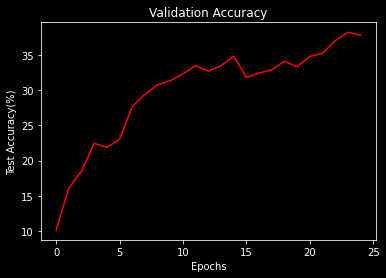

In [14]:
data_utils.plot_curve(val_acc, "Test Accuracy(%)")

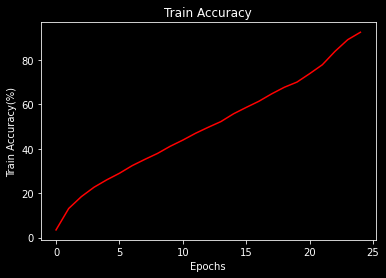

In [15]:
data_utils.plot_curve(train_acc, "Train Accuracy(%)")

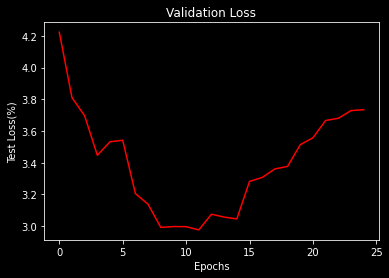

In [16]:
data_utils.plot_curve(val_loss, "Test Loss(%)")

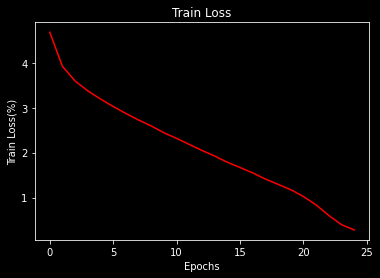

In [17]:
data_utils.plot_curve(train_loss, "Train Loss(%)")

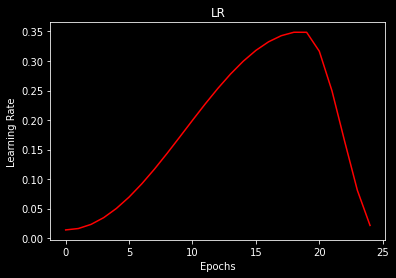

In [18]:
data_utils.plot_curve(learning_rate, "Learning Rate")

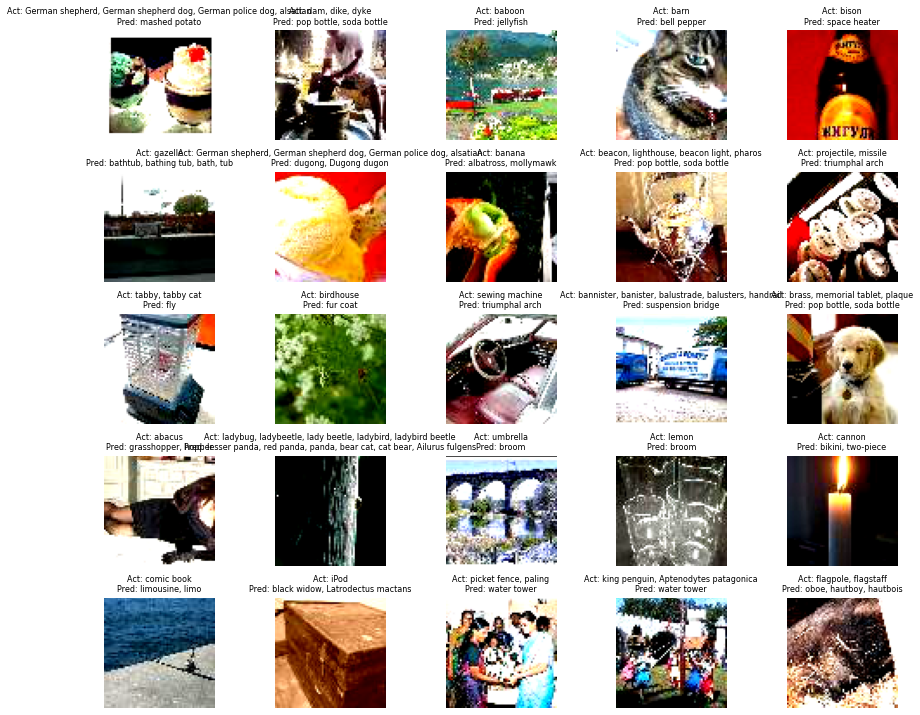

In [29]:
test_misc_images = [test_misc_images[i] for i in range(25)]
data_utils.plot_misclassified_rgb(test_misc_images, 'misclassified.png',plot_size=(20,12), config=modelconfig)

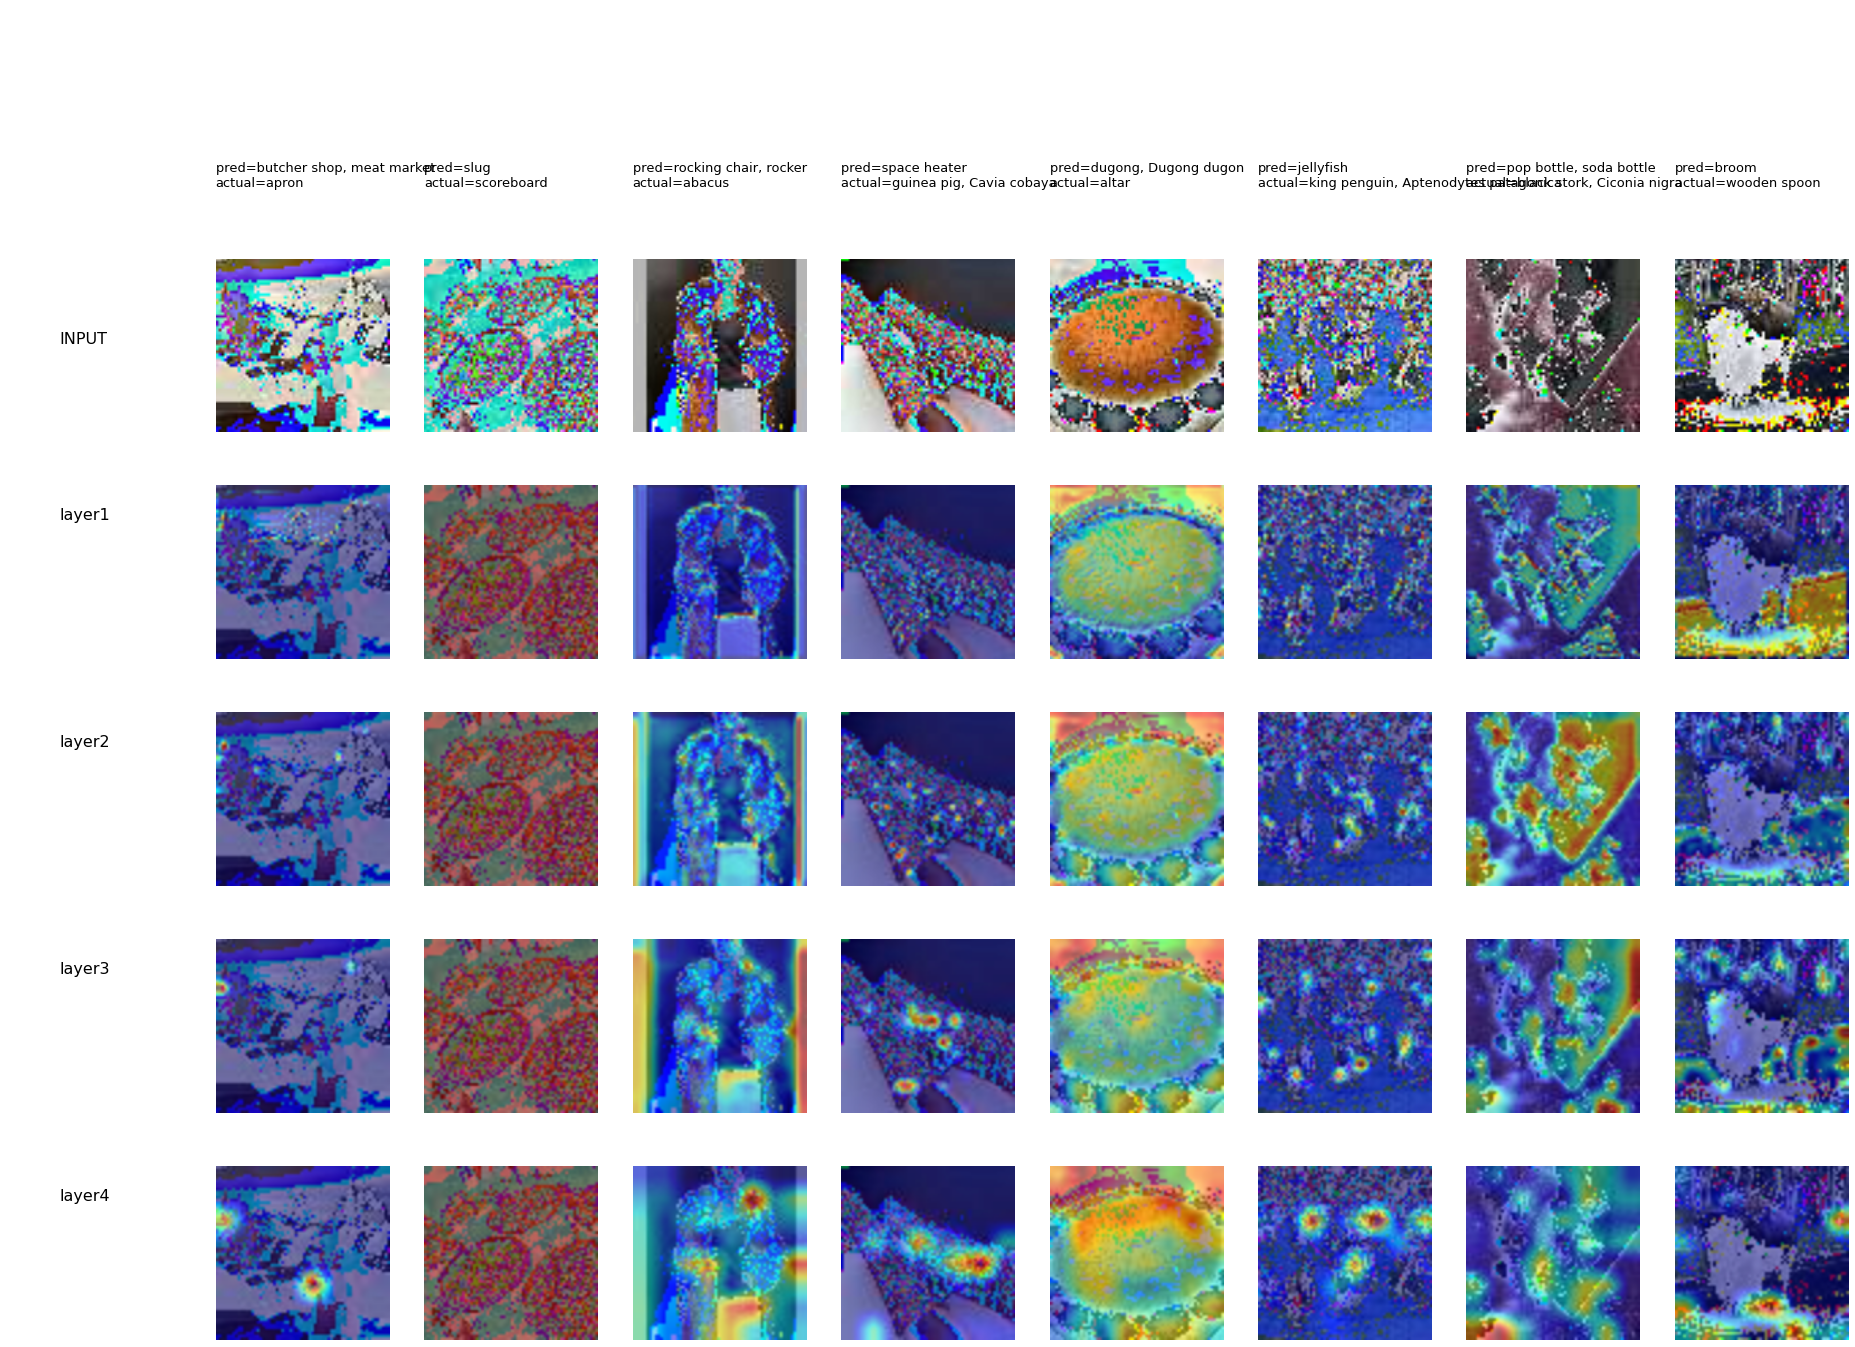

In [31]:
image_size = (3,32,32)
device = modelconfig.device
target_layers = ["layer1", "layer2", "layer3", "layer4"]

images = [x['image'] for x in test_misc_images]
target_classes = [l['label'] for l in test_misc_images]
gradcam_layers, probs, predicted_classes = generate_gcam(images, device, target_classes, model, target_layers)

plot_gcam(modelconfig, gradcam_layers, images, target_classes, target_layers, modelconfig.classes, image_size, predicted_classes)